# This code implements segmentation of pathological regions from retinal images using a U-net model with depth 4 and tensorflow 2.x versions.

## This code implements binary classification
## This model is adapted from the original codebase in https://github.com/HZCTony/U-net-with-multiple-classification

In [1]:
#This code snippet helps if your computer has RTX 2070 GPU. If not then comment this cell.
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# A. Lets start by stepwise defining all libraries and functions needed to generate the model and pre-process the data

In [2]:
#Step 1: Load libraries for the U-net Model
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
#from tensorflow import keras
import tensorflow as tf

In [3]:
img_size=(256,256)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = keras.sum(y_true * y_pred, axis=[1,2,3])
    union = keras.sum(y_true, axis=[1,2,3]) + keras.sum(y_pred, axis=[1,2,3])
    return keras.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [4]:
#Step 2: Define the U-net model with Depth=4
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5, training=True)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 0.0001), loss = dice_coef_loss, metrics = dice_coef)
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [5]:
n_class=2
#Hamorrhages vs background

In [6]:
#Step 3:Define functions for pre-processing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import scipy.misc as sc


def adjustData(img,mask,flag_multi_class,n_class):
    
    if(flag_multi_class):
        img /= 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (n_class,))
        for i in range(n_class):
            
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img)>1):
        img = img / 255
        mask = mask /255
    mask[mask > 0.1] = 1
    mask[mask <= 0.1] = 0
        #print(np.shape(mask),np.shape(img))
    return (img,mask)



def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,n_class = n_class,save_to_dir = None,target_size = img_size,seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        #'./',
        train_path,
        classes = [image_folder],
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        class_mode=None,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        class_mode=None,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,n_class)
        yield (img,mask)


def testGenerator(test_path,target_size = img_size,flag_multi_class = True,as_gray = True):
    files=sorted(os.listdir(test_path))
    num_image=len(files)
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,files[i]),as_gray = as_gray)
        print(files[i])
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        #print(np.max(img))
        yield img

In [7]:
#Step 4: Define function to save the test images
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i] = color_dict[i]
      
    return img_out


def saveResult(img_path,save_path,npyfile,flag_multi_class = False,num_class = 2):
    files=os.listdir(img_path)
    #print(len(img_path))
    #print(len(npyfile))
    
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        #img1=np.array(((img - np.min(img))/np.ptp(img))>0.6).astype(float)
        img[img>0.5]=1
        img[img<=0.5]=0
        io.imsave(os.path.join(save_path, files[i]),img)
        
        
        
def SaveResultwImage(img_path,save_path,npyfile,target_size=img_size,flag_multi_class = False,num_class = 2):
    files=os.listdir(img_path)
    #print(len(img_path))
    #print(len(npyfile))
    
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        #img1=np.array(((img - np.min(img))/np.ptp(img))>0.6).astype(float)
        img[img>0.5]=1
        img[img<=0.5]=0
        
        I = io.imread(os.path.join(img_path,files[i]))
        I = trans.resize(I,target_size)
        I[:,:,0]=np.true_divide((I[:,:,0]+img),2)
        io.imsave(os.path.join(save_path, files[i]),I)        

In [8]:
#Step 5: Define functions to evaluate the output
import sklearn.metrics as sm

def get_confusion_matrix_elements(groundtruth_list, predicted_list):
    """returns confusion matrix elements i.e TN, FP, FN, TP as floats
	See example code for helper function definitions
    """
    tn, fp, fn, tp = sm.confusion_matrix(groundtruth_list, predicted_list,labels=[0,1]).ravel()
    tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp

def get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list):
    """returns precision, recall, IoU and accuracy metrics
	"""
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    prec=tp/(tp+fp)
    rec=tp/(tp+fn)
    IoU=tp/(tp+fp+fn)
    
    return prec,rec,IoU,accuracy

def get_f1_score(groundtruth_list, predicted_list):
    """Return f1 score covering edge cases"""

    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score

def get_validation_metrics(groundtruth,predicted):
    """Return all output metrics. Input is binary images"""
   
    u,v=np.shape(groundtruth)
    groundtruth_list=np.reshape(groundtruth,(u*v,))
    predicted_list=np.reshape(predicted,(u*v,))
    prec,rec,IoU,acc=get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list)
    f1_score=get_f1_score(groundtruth_list, predicted_list)
   # print("Precision=",prec, "Recall=",rec, "IoU=",IoU, "acc=",acc, "F1=",f1_score)
    return prec,rec,IoU,acc,f1_score

def evalResult(gth_path,npyfile,target_size=img_size,flag_multi_class = False,num_class = 2):
    files=sorted(os.listdir(gth_path))
    #print(files)
    prec=0
    rec=0
    acc=0
    IoU=0
    f1_score=0
    for i,item in enumerate(npyfile):
        img = item[:,:,0]
        gth = io.imread(os.path.join(gth_path,files[i]))
        gth = trans.resize(gth,target_size)
        if(np.sum(img)>0):
            img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
        if(np.sum(gth)>0):
            gth1=np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
            gth1=(gth1>0.1).astype(int)
        p,r,I,a,f=get_validation_metrics(gth1,img1)
        prec=prec+p
        rec=rec+r
        acc=acc+a
        IoU=IoU+I
        f1_score=f1_score+f
    print("Precision=",prec/(i+1), "Recall=",rec/(i+1), "IoU=",IoU/(i+1), "acc=",acc/(i+1), "F1=",f1_score/(i+1))    

# All definitions are now done! Lets start using the functions now...
# B. Call to image data generator, model initialization, followed by model fitting.

In [9]:
#Step 1: Call to image data generator in keras
data_gen_args = dict(rotation_range=0.3,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.1,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    fill_mode='nearest')
PATH='./train/'

In [10]:
if not os.path.exists(PATH+'aug_bin'):
    os.makedirs(PATH+'aug_bin')
    
if not os.path.exists(PATH+'pred'):
    os.makedirs(PATH+'pred')    


In [11]:
data_gen = trainGenerator(3,PATH,'images','GT',data_gen_args, save_to_dir = None)

Epoch 0
Found 27 images belonging to 1 classes.
Found 27 images belonging to 1 classes.


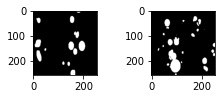

Epoch 1


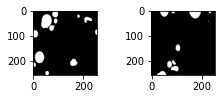

Epoch 2


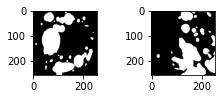

Epoch 3


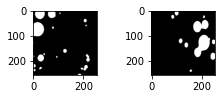

Epoch 4


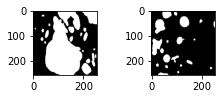

In [12]:
for e in range(5):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in data_gen:
        #print(np.max(x_batch))
        for i in range(0, 2):
            plt.subplot(330+1 + i)
            plt.imshow(y_batch[i], cmap=plt.get_cmap('gray'))
        

        plt.show()
        
        break

In [13]:
#Step 2: Initialize the model. Train from scratch!
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
#Step 3: Initialize Tensorboard to monitor changes in Model Loss 
import datetime
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [15]:
#Visualize on tensorboard (move this above)
%tensorboard --logdir logs/fit

In [16]:
#Step 4: Fit the u-net model
#model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_DB1_bin.hdf5', monitor='loss',verbose=0)# save_best_only=True)
model.fit(data_gen,steps_per_epoch=20,epochs=60,verbose=1,callbacks=[tensorboard_callback])#,model_checkpoint])

Epoch 1/60
20/20 [==============================] - 59s 3s/step - loss: -0.2190 - dice_coef: 0.2190
Epoch 2/60
20/20 [==============================] - 61s 3s/step - loss: -0.2664 - dice_coef: 0.2664
Epoch 3/60
20/20 [==============================] - 61s 3s/step - loss: -0.2644 - dice_coef: 0.2644
Epoch 4/60
20/20 [==============================] - 61s 3s/step - loss: -0.2721 - dice_coef: 0.2721
Epoch 5/60
20/20 [==============================] - 61s 3s/step - loss: -0.2429 - dice_coef: 0.2429
Epoch 6/60
20/20 [==============================] - 61s 3s/step - loss: -0.2834 - dice_coef: 0.2834
Epoch 7/60
20/20 [==============================] - 61s 3s/step - loss: -0.2703 - dice_coef: 0.2703
Epoch 8/60
20/20 [==============================] - 61s 3s/step - loss: -0.2830 - dice_coef: 0.2830
Epoch 9/60
20/20 [==============================] - 61s 3s/step - loss: -0.2972 - dice_coef: 0.2972
Epoch 10/60
20/20 [==============================] - 61s 3s/step - loss: -0.2895 - dice_coef: 0.2895

# Final trained model is saved as unet_DB1.hdf5
# C. Run the trained model on test images and save the outputs, and evaluate pixel-level segmentation performance 

In [17]:
#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./test/images/'))
#Call test generator
test_gen = testGenerator('./test/images/')
#Return model outcome for each test image
results = model.predict_generator(test_gen,n_i,verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
image028.png
image029.png
62/62 [==============================] - 16s 263ms/step


In [18]:
#saveResult('./test/images/',PATH+'pred/',results)
SaveResultwImage('./test/images/',PATH+'pred/',results)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

In [19]:
evalResult('./test/GT/',results)

Precision= 0.15974676632177165 Recall= 0.14877634261539646 IoU= 0.09089278030868661 acc= 0.9795874318768901 F1= 0.12965776109622235


# Now we have replicated code for binary semantic segmentation for hemorrhages, specifically. Next, lets look at multi-class